Bayesian Statistics Made Simple
===

Code and exercises from my workshop on Bayesian statistics in Python.

Copyright 2016 Allen Downey

MIT License: https://opensource.org/licenses/MIT

In [1]:
from __future__ import print_function, division

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import math
import numpy as np
from scipy.special import gamma

from thinkbayes2 import Pmf, Suite
import thinkplot

## The World Cup Problem

We'll use λ to represent the hypothetical goal-scoring rate in goals per game.



To compute prior probabilities for values of λ, I'll use a Gamma distribution.  

The mean is 1.3, which is the average number of goals per team per game in World Cup play.

1.3103599490022562

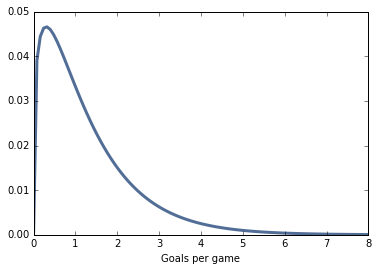

In [2]:
from thinkbayes2 import MakeGammaPmf

xs = np.linspace(0, 8, 101)
pmf = MakeGammaPmf(xs, 1.3)
thinkplot.Pdf(pmf)
thinkplot.Config(xlabel='Goals per game')
pmf.Mean()

**Exercise:**  Write a class called `Soccer` that extends `Suite` and defines `Likelihood`, which should compute the probability of the data (the time between goals in minutes) for a hypothetical goal-scoring rate, `lam`, in goals per game.

Hint: For a given value of `lam`, the time between goals is distributed exponentially.

Here's an outline to get you started:

In [3]:
class Soccer(Suite):
    """Represents hypotheses about goal-scoring rates."""

    def Likelihood(self, data, hypo):
        """Computes the likelihood of the data under the hypothesis.

        hypo: scoring rate in goals per game
        data: interarrival time in minutes
        """
        return 1

In [4]:
# Solution

class Soccer(Suite):
    """Represents hypotheses about goal-scoring rates."""

    def Likelihood(self, data, hypo):
        """Computes the likelihood of the data under the hypothesis.

        hypo: scoring rate in goals per game
        data: interarrival time in minutes
        """
        x = data / 90
        lam = hypo
        like = lam * math.exp(-lam * x)
        return like

Now we can create a `Soccer` object and initialize it with the prior Pmf:

1.3103599490022564

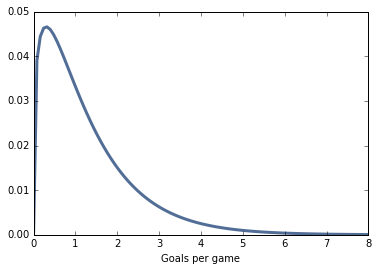

In [5]:
soccer = Soccer(pmf)
thinkplot.Pdf(soccer)
thinkplot.Config(xlabel='Goals per game')
soccer.Mean()

Here's the update after first goal at 11 minutes.

2.035267756093734

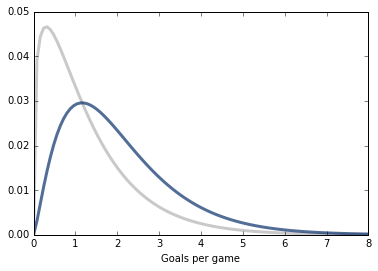

In [6]:
thinkplot.Pdf(soccer, color='0.7')
soccer.Update(11)
thinkplot.Pdf(soccer)
thinkplot.Config(xlabel='Goals per game')
soccer.Mean()

Here's the update after the second goal at 23 minutes (the time between first and second goals is 12 minutes).


2.6029902257702706

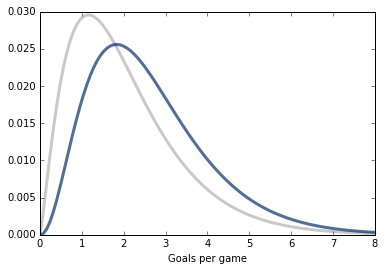

In [7]:
thinkplot.Pdf(soccer, color='0.7')
soccer.Update(12)
thinkplot.Pdf(soccer)
thinkplot.Config(xlabel='Goals per game')
soccer.Mean()

This distribution represents our belief about `lam` after two goals.

## Estimating the predictive distribution

Now to predict the number of goals in the remaining 67 minutes.  There are two sources of uncertainty:

1. We don't know the true value of λ.

2. Even if we did we wouldn't know how many goals would be scored.

We can quantify both sources of uncertainty at the same time, like this:

1. Choose a random values from the posterior distribution of λ.

2. Use the chosen value to generate a random number of goals.

If we run these steps many times, we can estimate the distribution of goals scored.

We can sample a value from the posterior like this:

In [8]:
lam = soccer.Random()
lam

5.2000000000000002

Given `lam`, the number of goals scored in the remaining 67 minutes comes from the Poisson distribution with parameter `lam * t`, with `t` in units of goals.

So we can generate a random value like this:

In [9]:
t = 67 / 90
np.random.poisson(lam * t)

9

If we generate a large sample, we can see the shape of the distribution:

3.8628

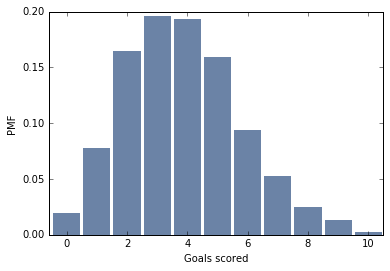

In [10]:
sample = np.random.poisson(lam * t, size=10000)
pmf = Pmf(sample)
thinkplot.Hist(pmf)
thinkplot.Config(xlabel='Goals scored', ylabel='PMF', xlim=[-0.6, 10.5])
pmf.Mean()

But that's based on a single value of `lam`, so it doesn't take into account both sources of uncertainty.  Instead, we should sample value values from the posterior distribution and generate one prediction for each.

**Exercise:** Write a few lines of code to

1. Use `Pmf.Sample` to generate a sample with `n=10000` from the posterior distribution `soccer`.

2. Use `np.random.poisson` to generate a random number of goals from the Poisson distribution with parameter $\lambda t$, where `t` is the remaining time in the game (in units of games).

3. Plot the distribution of the predicted number of goals, and print its mean.

4. What is the probability of scoring 5 or more goals in the remainder of the game?

1.9466000000000003

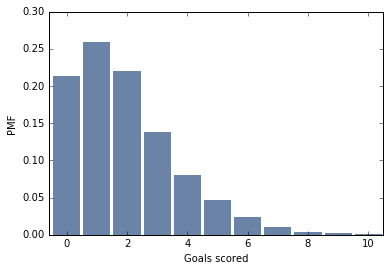

In [11]:
# Solution

lams = soccer.Sample(10000)
scores = np.random.poisson(lams * t)
pmf = Pmf(scores)
thinkplot.Hist(pmf)
thinkplot.Config(xlabel='Goals scored', ylabel='PMF', xlim=[-0.6, 10.5])
pmf.Mean()

In [12]:
# Solution

sum(scores>=5) / len(scores)

0.087400000000000005

## Computing the predictive distribution

Alternatively, we can compute the predictive distribution by making a mixture of Poisson distributions.

`MakePoissonPmf` makes a Pmf that represents a Poisson distribution.

In [13]:
from thinkbayes2 import MakePoissonPmf

If we assume that `lam` is the mean of the posterior, we can generate a predictive distribution for the number of goals in the remainder of the game.

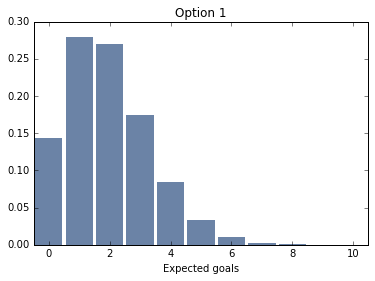

In [14]:
lam = soccer.Mean()
rem_time = 90 - 23
lt = lam * rem_time / 90
pred = MakePoissonPmf(lt, 10)
thinkplot.Hist(pred)
thinkplot.Config(title='Option 1', 
                 xlabel='Expected goals',
                 xlim=[-0.5, 10.5])

The predictive mean is about 2 goals.

In [15]:
pred.Mean()

1.9377241975748247

And the chance of scoring 5 more goals is still small.

In [16]:
pred.ProbGreater(4)

0.047208117119541912

But that answer is only approximate because it does not take into account our uncertainty about `lam`.

The correct method is to compute a weighted mixture of Poisson distributions, one for each possible value of `lam`.

The following figure shows the different predictive distributions for the different values of `lam`.

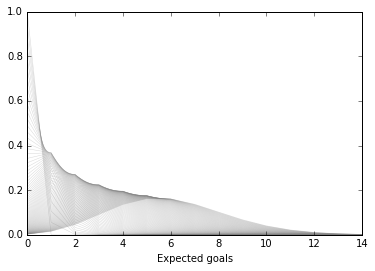

In [17]:
for lam, prob in soccer.Items():
    lt = lam * rem_time / 90
    pred = MakePoissonPmf(lt, 14)
    thinkplot.Pdf(pred, color='gray', alpha=0.3, linewidth=0.5)

thinkplot.Config(xlabel='Expected goals')

We can compute the mixture of these distributions by making a Meta-Pmf that maps from each Poisson Pmf to its probability.

In [18]:
metapmf = Pmf()

for lam, prob in soccer.Items():
    lt = lam * rem_time / 90
    pred = MakePoissonPmf(lt, 15)
    metapmf[pred] = prob

`MakeMixture` takes a Meta-Pmf (a Pmf that contains Pmfs) and returns a single Pmf that represents the weighted mixture of distributions:

In [19]:
def MakeMixture(metapmf, label='mix'):
    """Make a mixture distribution.

    Args:
      metapmf: Pmf that maps from Pmfs to probs.
      label: string label for the new Pmf.

    Returns: Pmf object.
    """
    mix = Pmf(label=label)
    for pmf, p1 in metapmf.Items():
        for x, p2 in pmf.Items():
            mix[x] += p1 * p2
    return mix

Here's the result for the World Cup problem.

In [20]:
mix = MakeMixture(metapmf)

And here's what the mixture looks like.

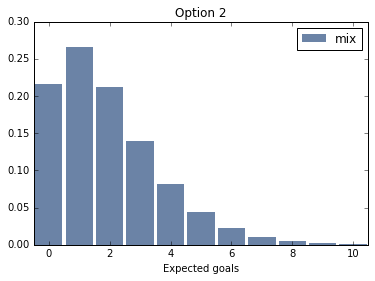

In [21]:
thinkplot.Hist(mix)
thinkplot.Config(title='Option 2', 
                 xlabel='Expected goals',
                 xlim=[-0.5, 10.5])

**Exercise:** Compute the predictive mean and the probability of scoring 5 or more additional goals.

In [22]:
# Solution

mix.Mean(), mix.ProbGreater(4)

(1.9377505061485507, 0.08565013621838527)